In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
from sklearn.linear_model import BayesianRidge, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from mplsoccer import Pitch, VerticalPitch
from IPython.display import set_matplotlib_formats
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

set_matplotlib_formats('retina')

/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_79466/2665664073.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/g4din/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_79466/2665664073.py:21: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inl

In [3]:
# Import data
damallsvenskan = pd.read_csv('csv/damallsvenskan_all.csv')
allsvenskan = pd.read_csv('csv/allsvenskan_all.csv')

# concatenate the two datasets
allsvenskan = pd.concat([allsvenskan, damallsvenskan])

In [4]:
# Assuming 'damallsvenskan' is your dataframe
# Create a column to identify if the next action is a goal
allsvenskan['is_next_goal'] = (allsvenskan['action'].shift(-1) == 'Goal').astype(int)

# Identify shots and whether they resulted in a goal
allsvenskan['is_shot'] = (allsvenskan['action'] == 'Shot').astype(int)
shots = allsvenskan[allsvenskan['is_shot'] == 1]

# Scale coordinates
scale_x = lambda x: x * 120 / 100
scale_y = lambda y: y * 80 / 100

# Apply scaling directly to the dataframe
shots['x'] = shots['xpos'].apply(scale_x)
shots['y'] = shots['ypos'].apply(scale_y)

# Convert 'is_next_goal' to boolean
shots['goal'] = shots['is_next_goal'].astype(bool)

# Select the required columns to form the new dataframe
data = shots[['x', 'y', 'goal']]

# Assuming 'header' is the column you want to add from 'allsvenskan'
data['header'] = shots['header']

data['penalty'] = shots['penalty']

/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_79012/1883369360.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots['x'] = shots['xpos'].apply(scale_x)
/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_79012/1883369360.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots['y'] = shots['ypos'].apply(scale_y)
/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_79012/1883369360.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [5]:
# Define functions for calculating distance and angle
def calculate_angle(x, y):
    width = 7.32
    new_x = 120 - x
    new_y = abs(y - 40)
    tan_theta = (width * new_x) / (new_x**2 + new_y**2 - (width/2)**2)
    theta = np.arctan(tan_theta) * (180 / np.pi)  # Convert radians to degrees
    return theta

def calculate_dist(x, y):
    return np.sqrt((120 - x)**2 + (40 - y)**2)

# Apply the functions to the dataframe
data['angle'] = data.apply(lambda row: calculate_angle(row['x'], row['y']), axis=1)
data['distance'] = data.apply(lambda row: calculate_dist(row['x'], row['y']), axis=1)

data.head(10)

/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_79012/1493875045.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['angle'] = data.apply(lambda row: calculate_angle(row['x'], row['y']), axis=1)
/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_79012/1493875045.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['distance'] = data.apply(lambda row: calculate_dist(row['x'], row['y']), axis=1)


,x,y,goal,header,penalty,angle,distance
74,109.2,55.2,False,False,False,13.305603,18.646179
106,111.6,24.8,False,False,False,12.043411,17.366635
114,98.4,30.4,False,False,False,16.169050,23.637259
163,114.0,39.2,True,True,False,62.110234,6.053098
269,92.4,44.0,False,False,False,14.805480,27.888349
337,111.6,24.8,False,False,False,12.043411,17.366635
353,116.4,37.6,True,True,False,78.577219,4.326662
428,112.8,26.4,True,False,False,13.274114,15.388307
453,104.4,41.6,True,False,False,26.155509,15.681837
483,109.2,48.0,False,False,False,25.299982,13.440238


In [6]:
# Data
X = data[['distance', 'angle', 'header', 'penalty']]
y = data['goal'].astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

## Support Vector Machine

In [7]:
# Initialize the SVM model with a pipeline
svm_model = make_pipeline(StandardScaler(), SVC(probability=True))

# Use Stratified K-Fold for cross-validation
cv = StratifiedKFold(n_splits=5)

# Cross-validation across the entire dataset for a general accuracy estimation
cv_accuracy_svm = cross_val_score(svm_model, X_train, y_train, cv=cv, scoring='accuracy').mean()
print(f'Cross-Validated Accuracy: {cv_accuracy_svm}')

# Fit the model on the training data
svm_model.fit(X_train, y_train)

# Predictions
y_pred = svm_model.predict(X_test)
y_pred_proba = svm_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class

# Evaluate the model
test_accuracy_svm = accuracy_score(y_test, y_pred)
precision_svm = precision_score(y_test, y_pred)
recall_svm = recall_score(y_test, y_pred)
f1_svm = f1_score(y_test, y_pred)
roc_auc_svm = roc_auc_score(y_test, y_pred_proba)

# Print the evaluation metrics
print(f'Test Accuracy: {test_accuracy_svm}')
print(f'Precision: {precision_svm}')
print(f'Recall: {recall_svm}')
print(f'F1 Score: {f1_svm}')
print(f'ROC AUC Score: {roc_auc_svm}')

Cross-Validated Accuracy: 0.9011250654107797
Test Accuracy: 0.9022501308215594
Precision: 0.7671957671957672
Recall: 0.14009661835748793
F1 Score: 0.2369281045751634
ROC AUC Score: 0.6011800594225578


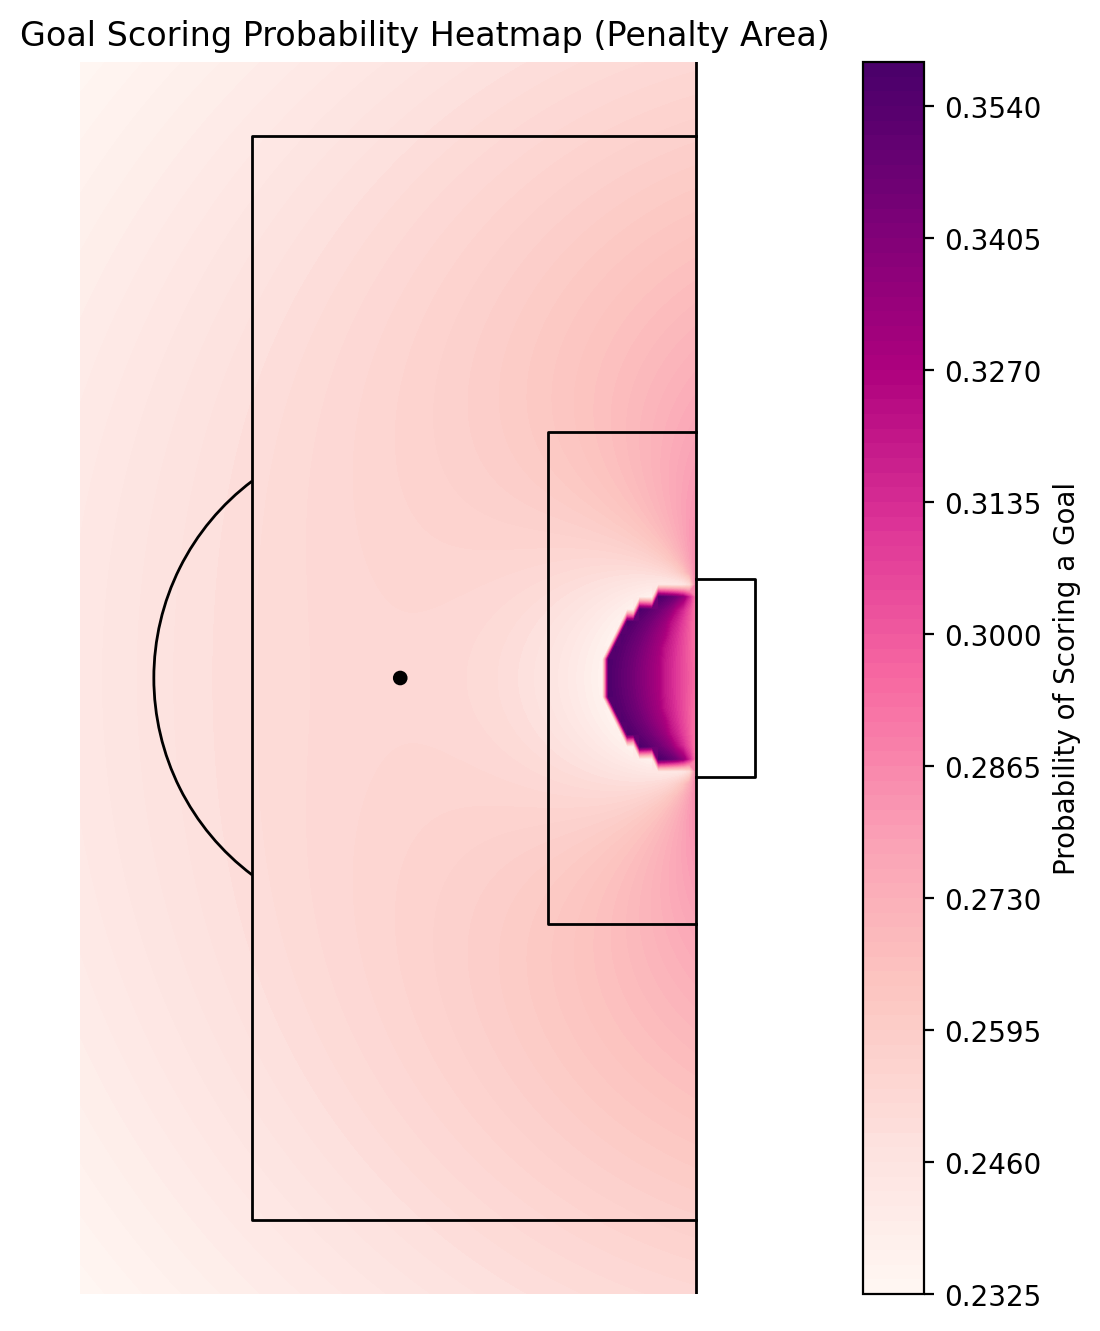

In [8]:
# Adjusted grid for higher resolution
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution
xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Assuming header is binary, let's add header = 0 for non-header attempts
# Update this line to create a full feature set including the header
# For simplicity, this example assumes all attempts are non-header. Adjust if needed.
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0] for x, y in grid_points])  # Assuming header=0

# Scale the features as before and predict goal probabilities
scaled_full_grid_points = svm_model.named_steps['standardscaler'].transform(full_grid_points)  # Use fitted scaler
goal_probabilities = svm_model.predict_proba(scaled_full_grid_points)[:, 1]  # Probability predictions

# Reshape for plotting
goal_prob_matrix = goal_probabilities.reshape(xx.shape)

# Plotting with increased resolution
fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_prob_matrix, cmap='RdPu', levels=100, zorder=1)  # Increase levels for smoother gradient
fig.colorbar(contour, ax=ax, label='Probability of Scoring a Goal')
ax.set_title('Goal Scoring Probability Heatmap (Penalty Area)')

# Zoom in to the penalty area
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)

plt.show()

## Decision Tree 

In [9]:
# Initialize the Decision Tree model
tree_model = DecisionTreeClassifier(max_depth=5)

# Use Stratified K-Fold for cross-validation
cv = StratifiedKFold(n_splits=5)

# Cross-validation across the entire dataset for a general accuracy estimation
cv_accuracy_dt = cross_val_score(tree_model, X_train, y_train, cv=cv, scoring='accuracy').mean()
print(f'Cross-Validated Accuracy: {cv_accuracy_dt}')

# Fit the model on the training data
tree_model.fit(X_train, y_train)

# Predictions
y_pred = tree_model.predict(X_test)
y_pred_proba = tree_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class

# Evaluate the model
test_accuracy_dt = accuracy_score(y_test, y_pred)
precision_dt = precision_score(y_test, y_pred)
recall_dt = recall_score(y_test, y_pred)
f1_dt = f1_score(y_test, y_pred)
roc_auc_dt = roc_auc_score(y_test, y_pred_proba)

# Print the evaluation metrics
print(f'Test Accuracy: {test_accuracy_dt}')
print(f'Precision: {precision_dt}')
print(f'Recall: {recall_dt}')
print(f'F1 Score: {f1_dt}')
print(f'ROC AUC Score: {roc_auc_dt}')

Cross-Validated Accuracy: 0.9006802721088436
Test Accuracy: 0.9020408163265307
Precision: 0.751269035532995
Recall: 0.14299516908212562
F1 Score: 0.24025974025974026
ROC AUC Score: 0.7699297475675309


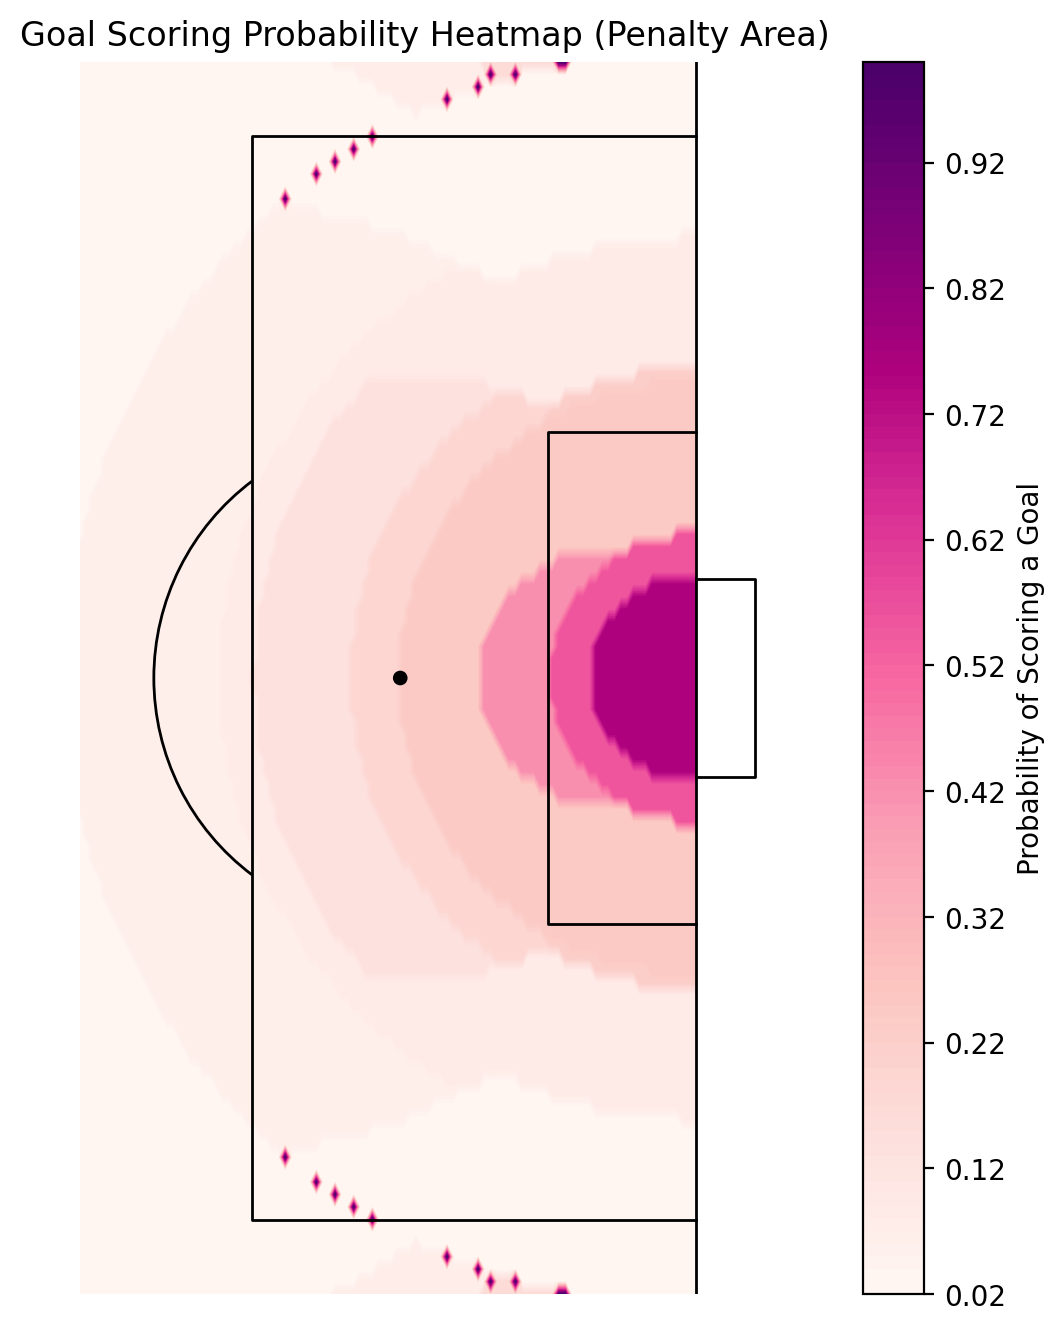

In [10]:
# Plot
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution

xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0] for x, y in grid_points])

goal_probabilities = tree_model.predict_proba(full_grid_points)[:, 1]  # Probability predictions
goal_prob_matrix = goal_probabilities.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_prob_matrix, cmap='RdPu', levels=100, zorder=1)  # Increase levels for smoother gradient
fig.colorbar(contour, ax=ax, label='Probability of Scoring a Goal')
ax.set_title('Goal Scoring Probability Heatmap (Penalty Area)')
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)

plt.show()

## Random Forest

In [12]:
# Initialize the Random Forest model
forest_model = RandomForestClassifier(n_estimators=100, max_depth=5)

# Use Stratified K-Fold for cross-validation
cv = StratifiedKFold(n_splits=5)

# Cross-validation across the entire dataset for a general accuracy estimation
cv_accuracy_rm = cross_val_score(forest_model, X_train, y_train, cv=cv, scoring='accuracy').mean()
print(f'Cross-Validated Accuracy: {cv_accuracy_rm}')

# Fit the model on the training data
forest_model.fit(X_train, y_train)

# Predictions
y_pred = forest_model.predict(X_test)
y_pred_proba = forest_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class

# Evaluate the model
test_accuracy_rm = accuracy_score(y_test, y_pred)
precision_rm = precision_score(y_test, y_pred)
recall_rm = recall_score(y_test, y_pred)
f1_rm = f1_score(y_test, y_pred)
roc_auc_rm = roc_auc_score(y_test, y_pred_proba)

# Print the evaluation metrics
print(f'Test Accuracy: {test_accuracy_rm}')
print(f'Precision: {precision_rm}')
print(f'Recall: {recall_rm}')
print(f'F1 Score: {f1_rm}')
print(f'ROC AUC Score: {roc_auc_rm}')

Cross-Validated Accuracy: 0.9009942438513867
Test Accuracy: 0.9023547880690738
Precision: 0.7741935483870968
Recall: 0.1391304347826087
F1 Score: 0.23587223587223588
ROC AUC Score: 0.7757793540631874


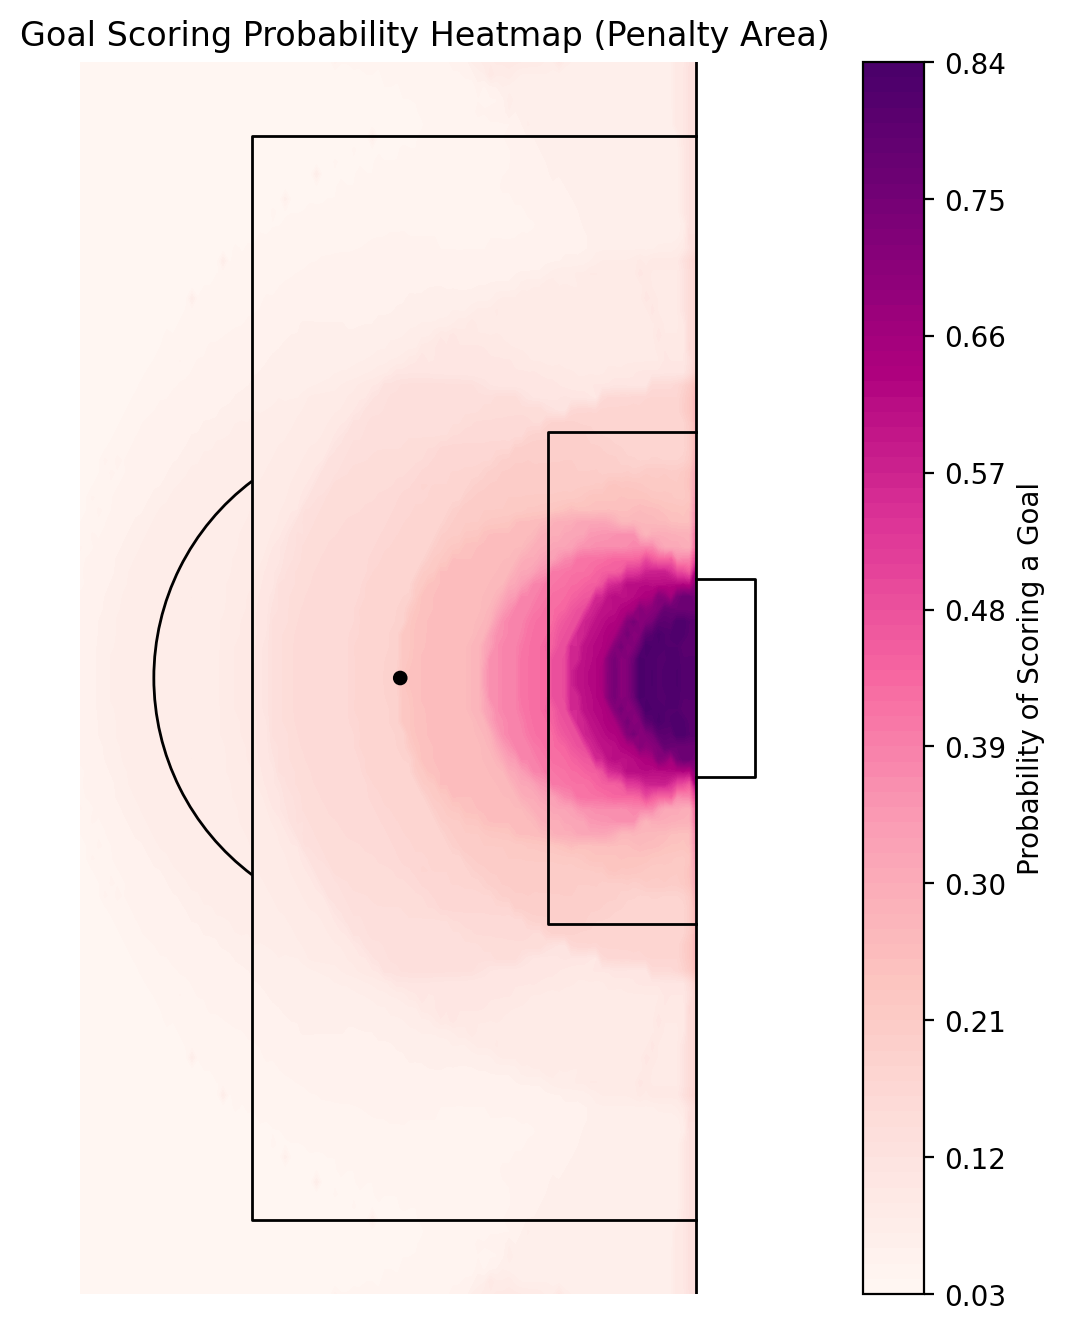

In [13]:
# Plot
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution

xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0] for x, y in grid_points])

goal_probabilities = forest_model.predict_proba(full_grid_points)[:, 1]  # Probability predictions
goal_prob_matrix = goal_probabilities.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_prob_matrix, cmap='RdPu', levels=100, zorder=1)  # Increase levels for smoother gradient
fig.colorbar(contour, ax=ax, label='Probability of Scoring a Goal')
ax.set_title('Goal Scoring Probability Heatmap (Penalty Area)')
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)

plt.show()

In [14]:
# Initialize the Neural Network model
nn_model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000)

# Use Stratified K-Fold for cross-validation
cv = StratifiedKFold(n_splits=5)

# Note: Cross-validating neural networks can be computationally expensive, so adjust n_splits accordingly

# Cross-validation across the entire dataset for a general accuracy estimation
cv_accuracy_nn = cross_val_score(nn_model, X_train, y_train, cv=cv, scoring='accuracy').mean()
print(f'Cross-Validated Accuracy: {cv_accuracy_nn}')

# Fit the model on the training data
nn_model.fit(X_train, y_train)

# Predictions
y_pred = nn_model.predict(X_test)
y_pred_proba = nn_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class

# Evaluate the model
test_accuracy_nn = accuracy_score(y_test, y_pred)
precision_nn = precision_score(y_test, y_pred)
recall_nn = recall_score(y_test, y_pred)
f1_nn = f1_score(y_test, y_pred)
roc_auc_nn = roc_auc_score(y_test, y_pred_proba)

# Print the evaluation metrics
print(f'Test Accuracy: {test_accuracy_nn}')
print(f'Precision: {precision_nn}')
print(f'Recall: {recall_nn}')
print(f'F1 Score: {f1_nn}')
print(f'ROC AUC Score: {roc_auc_nn}')

Cross-Validated Accuracy: 0.9000261643118787
Test Accuracy: 0.902668759811617
Precision: 0.7777777777777778
Recall: 0.14202898550724638
F1 Score: 0.24019607843137256
ROC AUC Score: 0.7764952598035879


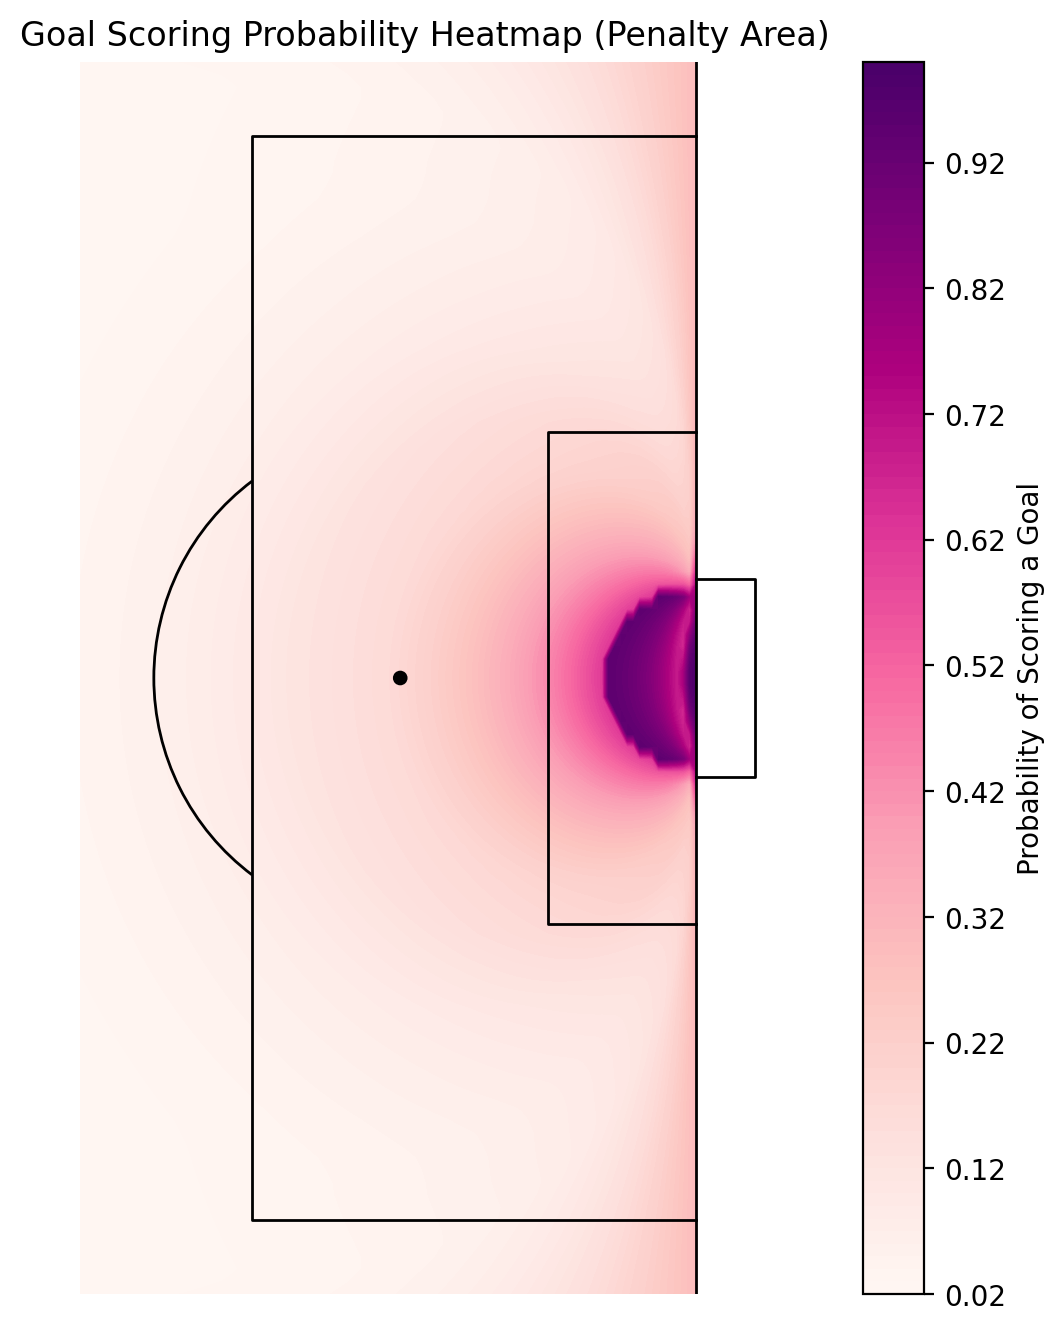

In [15]:
# Plot 
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution

xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0] for x, y in grid_points])

goal_probabilities = nn_model.predict_proba(full_grid_points)[:, 1]  # Probability predictions
goal_prob_matrix = goal_probabilities.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_prob_matrix, cmap='RdPu', levels=100, zorder=1)  # Increase levels for smoother gradient
fig.colorbar(contour, ax=ax, label='Probability of Scoring a Goal')
ax.set_title('Goal Scoring Probability Heatmap (Penalty Area)')
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)

plt.show()

## Logistic Regression

In [16]:
# Initialize the Logistic Regression model
log_model = LogisticRegression(max_iter=1000)  # Adjust max_iter if needed for convergence

# Use Stratified K-Fold for cross-validation
cv = StratifiedKFold(n_splits=5)

# Cross-validation across the entire dataset for a general accuracy estimation
cv_accuracy_log = cross_val_score(log_model, X_train, y_train, cv=cv, scoring='accuracy').mean()
print(f'Cross-Validated Accuracy: {cv_accuracy_log}')

# Fit the model on the training data
log_model.fit(X_train, y_train)

# Predictions
y_pred = log_model.predict(X_test)
y_pred_proba = log_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class

# Evaluate the model
test_accuracy_log = accuracy_score(y_test, y_pred)
precision_log = precision_score(y_test, y_pred)
recall_log = recall_score(y_test, y_pred)
f1_log = f1_score(y_test, y_pred)
roc_auc_log = roc_auc_score(y_test, y_pred_proba)

# Print the evaluation metrics
print(f'Test Accuracy: {test_accuracy_log}')
print(f'Precision: {precision_log}')
print(f'Recall: {recall_log}')
print(f'F1 Score: {f1_log}')
print(f'ROC AUC Score: {roc_auc_log}')

Cross-Validated Accuracy: 0.8986394557823129
Test Accuracy: 0.8994243851386708
Precision: 0.8303571428571429
Recall: 0.08985507246376812
F1 Score: 0.16216216216216217
ROC AUC Score: 0.7719269238620126


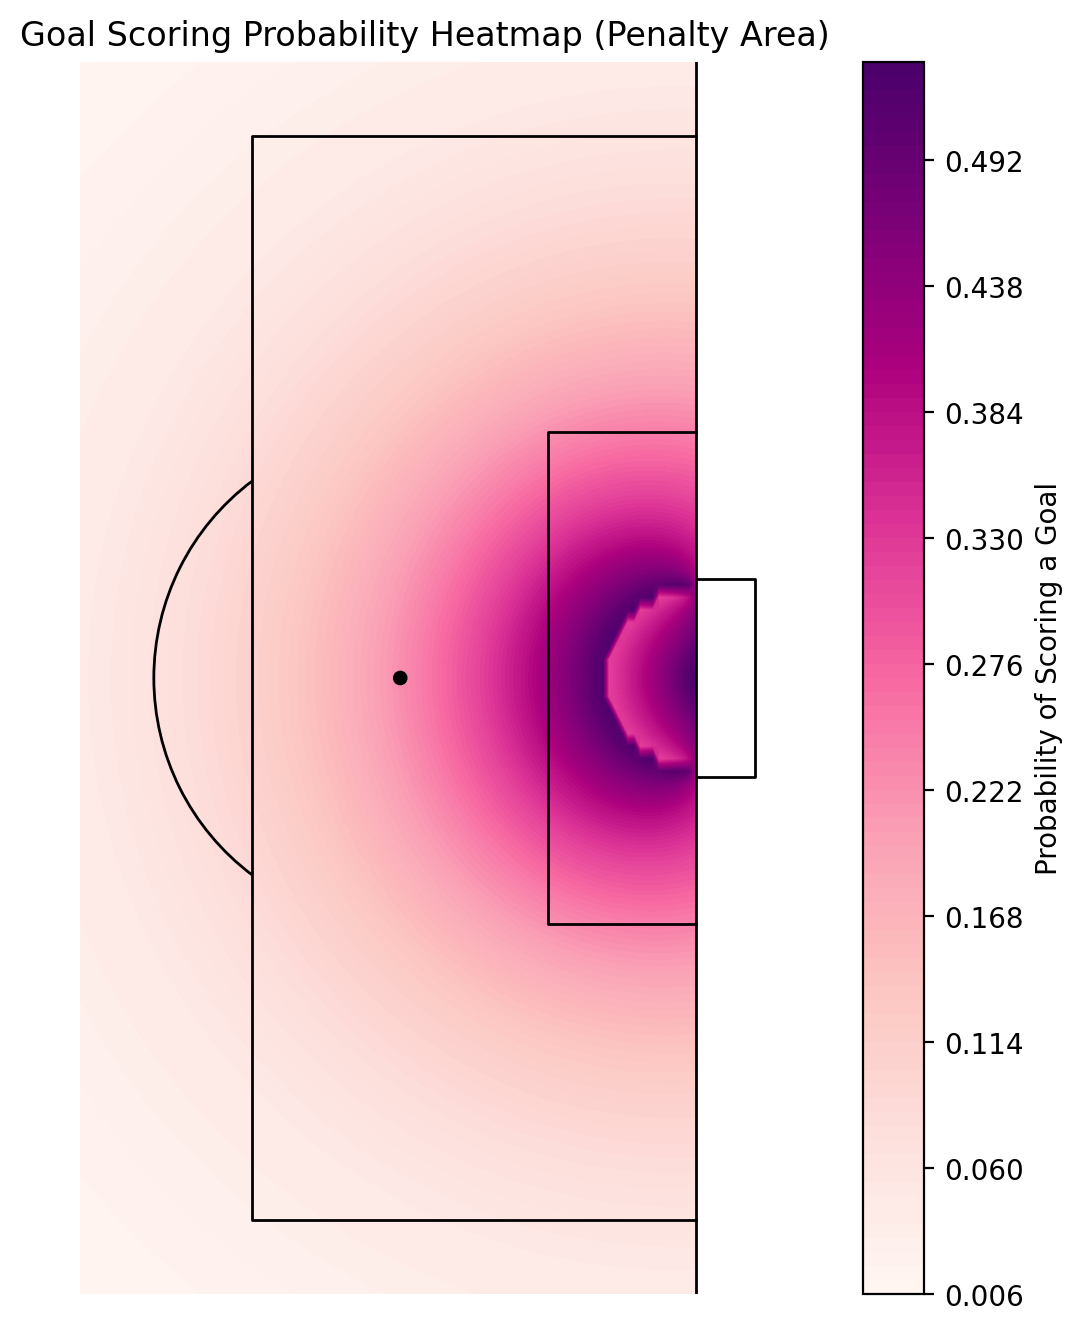

In [17]:
# Plot
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution

xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0] for x, y in grid_points])

goal_probabilities = log_model.predict_proba(full_grid_points)[:, 1]  # Probability predictions
goal_prob_matrix = goal_probabilities.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_prob_matrix, cmap='RdPu', levels=100, zorder=1)  # Increase levels for smoother gradient
fig.colorbar(contour, ax=ax, label='Probability of Scoring a Goal')
ax.set_title('Goal Scoring Probability Heatmap (Penalty Area)')
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)

plt.show()

## Linear Regression

In [31]:
# Initialize the Linear Regression model
linear_model = make_pipeline(PolynomialFeatures(2), BayesianRidge())
linear_model.fit(X_train, y_train)

# Predictions
y_pred = linear_model.predict(X_test)

# Evaluate the model
mae_linear = mean_absolute_error(y_test, y_pred)
mse_linear = mean_squared_error(y_test, y_pred)
rmse_linear = np.sqrt(mse_linear) # Calculating RMSE
r2_linear = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae_linear}')
print(f'Mean Squared Error (MSE): {mse_linear}')
print(f'Root Mean Squared Error (RMSE): {rmse_linear}')
print(f'R-squared (R²): {r2_linear}')

Mean Absolute Error (MAE): 0.1622425024872164
Mean Squared Error (MSE): 0.08105162246027549
Root Mean Squared Error (RMSE): 0.28469566638829524
R-squared (R²): 0.16084313650531923


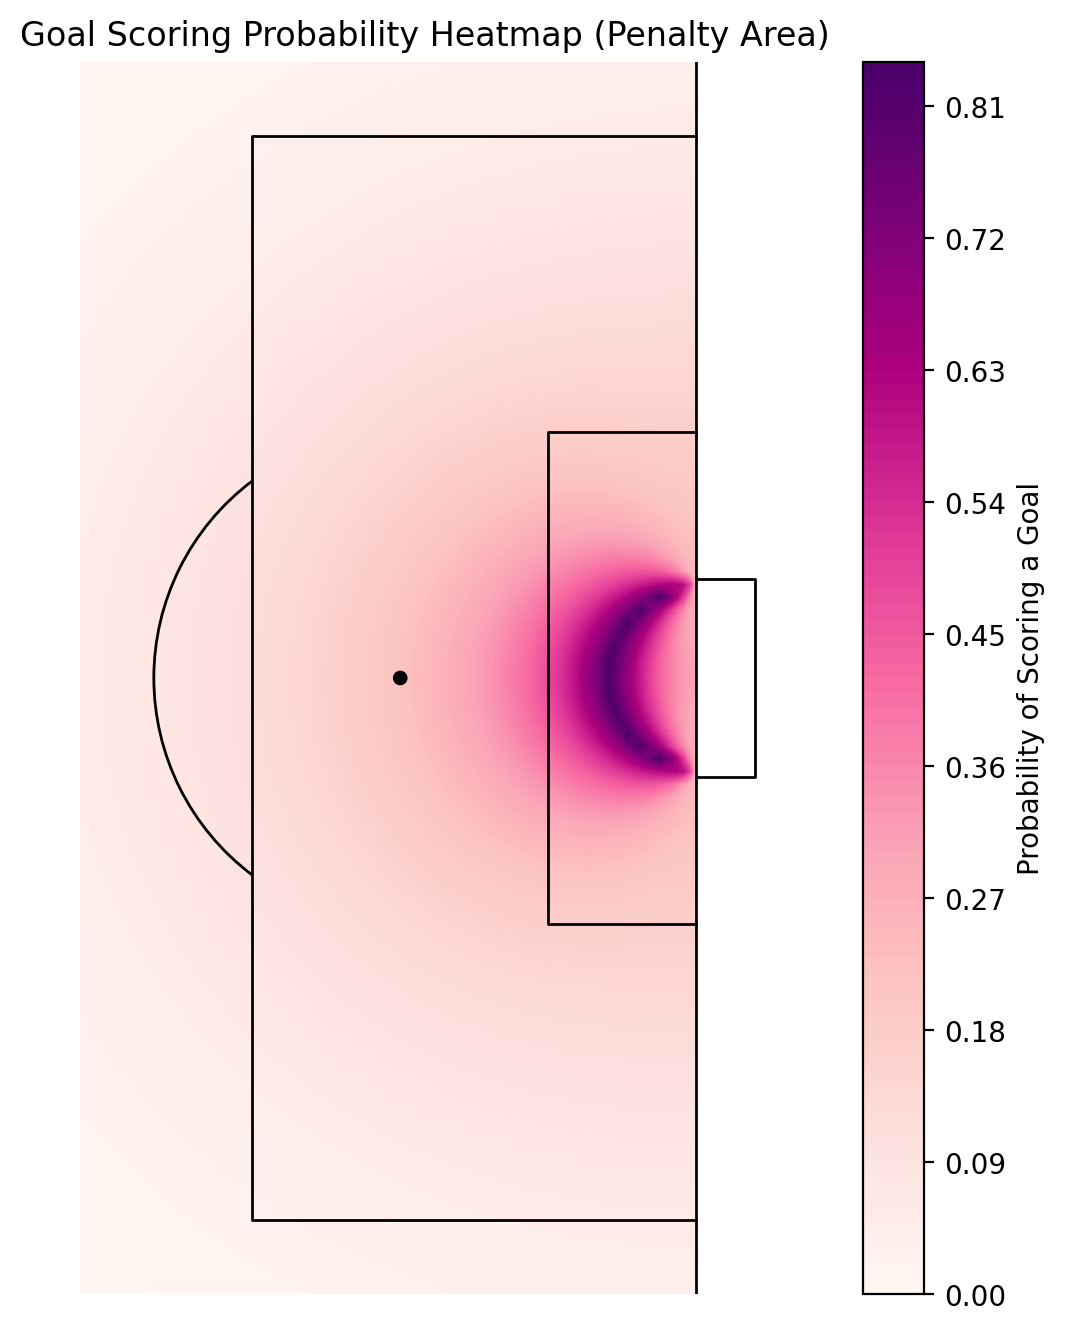

In [19]:
# Plot
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution

xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0] for x, y in grid_points])

goal_probabilities = linear_model.predict(full_grid_points)  # Probability predictions
goal_prob_matrix = goal_probabilities.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_prob_matrix, cmap='RdPu', levels=100, zorder=1)  # Increase levels for smoother gradient
fig.colorbar(contour, ax=ax, label='Probability of Scoring a Goal')
ax.set_title('Goal Scoring Probability Heatmap (Penalty Area)')
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)

plt.show()

## XGBoost

In [20]:
# Initialize the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Use Stratified K-Fold for cross-validation
cv = StratifiedKFold(n_splits=5)

# Cross-validation across the entire dataset for a general accuracy estimation
cv_accuracy_xgb = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='accuracy').mean()
print(f'Cross-Validated Accuracy: {cv_accuracy_xgb}')

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class

# Evaluate the model
test_accuracy_xgb = accuracy_score(y_test, y_pred)
precision_xgb = precision_score(y_test, y_pred)
recall_xgb = recall_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba)

# Print the evaluation metrics
print(f'Test Accuracy: {test_accuracy_xgb}')
print(f'Precision: {precision_xgb}')
print(f'Recall: {recall_xgb}')
print(f'F1 Score: {f1_xgb}')
print(f'ROC AUC Score: {roc_auc_xgb}')

Cross-Validated Accuracy: 0.9002878074306647
Test Accuracy: 0.902668759811617
Precision: 0.7692307692307693
Recall: 0.14492753623188406
F1 Score: 0.24390243902439024
ROC AUC Score: 0.761098523508199


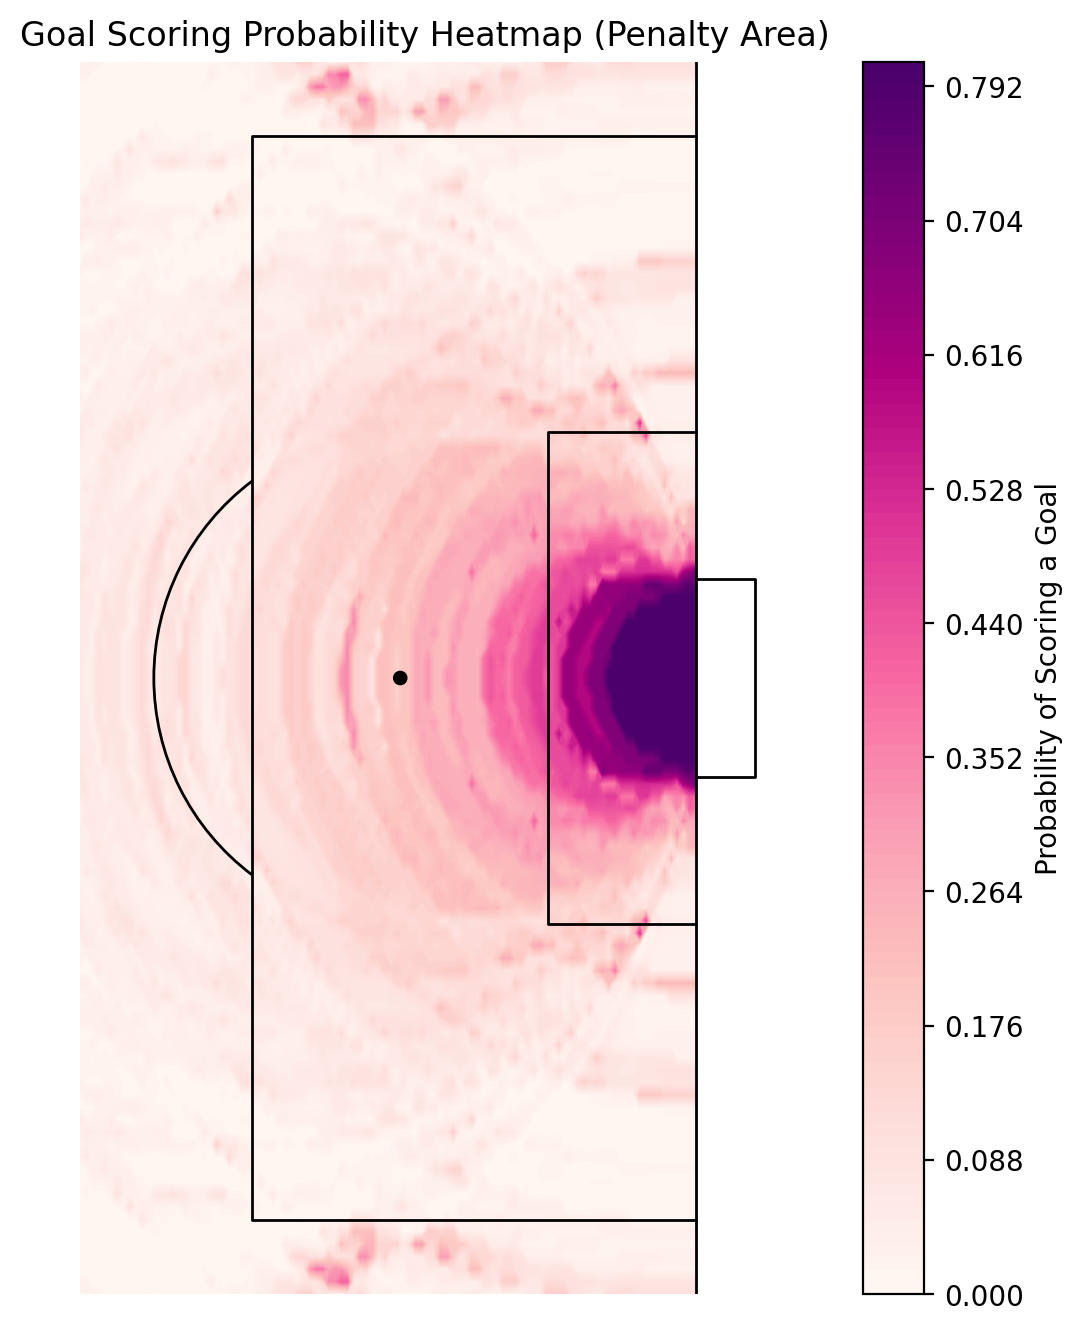

In [21]:
# Plot
x_values = np.linspace(95, 120, 100)  # Increase the number of points for finer resolution
y_values = np.linspace(15, 65, 100)   # Increase the number of points for finer resolution

xx, yy = np.meshgrid(x_values, y_values)
grid_points = np.c_[xx.ravel(), yy.ravel()]
full_grid_points = np.array([[calculate_dist(x, y), calculate_angle(x, y), 0, 0] for x, y in grid_points])

goal_probabilities = xgb_model.predict_proba(full_grid_points)[:, 1]  # Probability predictions
goal_prob_matrix = goal_probabilities.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(12, 8))
pitch = Pitch(half=True, goal_type='box', line_zorder=2, line_color='black', linewidth=1)
pitch.draw(ax=ax)
contour = ax.contourf(xx, yy, goal_prob_matrix, cmap='RdPu', levels=100, zorder=1)  # Increase levels for smoother gradient
fig.colorbar(contour, ax=ax, label='Probability of Scoring a Goal')
ax.set_title('Goal Scoring Probability Heatmap (Penalty Area)')
ax.set_xlim(95, 123)
ax.set_ylim(15, 65)

plt.show()

## Comparing Test Accuracy

In [37]:
# Data for classification models
models = ['SVM', 'Decision Tree', 'Random Forest', 'Neural Network', 'Logistic Regression', 'XGBoost']
accuracies = [test_accuracy_svm, test_accuracy_dt, test_accuracy_rm, test_accuracy_nn, test_accuracy_log, test_accuracy_xgb]
precisions = [precision_svm, precision_dt, precision_rm, precision_nn, precision_log, precision_xgb]
recalls = [recall_svm, recall_dt, recall_rm, recall_nn, recall_log, recall_xgb]
f1_scores = [f1_svm, f1_dt, f1_rm, f1_nn, f1_log, f1_xgb]
roc_auc_scores = [roc_auc_svm, roc_auc_dt, roc_auc_rm, roc_auc_nn, roc_auc_log, roc_auc_xgb]

# Summary DataFrame for classification models
classification_summary_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores,
    'ROC AUC': roc_auc_scores
})

classification_summary_df = classification_summary_df.sort_values(by='F1 Score', ascending=False)
classification_summary_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
5,XGBoost,0.902669,0.769231,0.144928,0.243902,0.761099
1,Decision Tree,0.902041,0.751269,0.142995,0.240260,0.769930
3,Neural Network,0.902669,0.777778,0.142029,0.240196,0.776495
0,SVM,0.902250,0.767196,0.140097,0.236928,0.601180
2,Random Forest,0.902355,0.774194,0.139130,0.235872,0.775779
4,Logistic Regression,0.899424,0.830357,0.089855,0.162162,0.771927


In [33]:
# Data for Linear Regression model
linear_regression_metrics = ['Mean Absolute Error', 'Mean Squared Error', 'Root Mean Squared Error', 'R-squared']
linear_regression_values = [mae_linear, mse_linear, rmse_linear, r2_linear]

# Correctly structured DataFrame for Linear Regression model
linear_regression_summary_df = pd.DataFrame({
    'Metric': linear_regression_metrics,
    'Value': linear_regression_values
})

# Display the Linear Regression Model Summary
linear_regression_summary_df

,Metric,Value
0,Mean Absolute Error,0.162243
1,Mean Squared Error,0.081052
2,Root Mean Squared Error,0.284696
3,R-squared,0.160843
